In [1]:
import re

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt



from scipy.spatial.distance import pdist

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# load stopwords

# selected after observing results without stopwords
stopwords = [

  'the',

  'about',

  'an',

  'and',

  'are',

  'at',

  'be',

  'can',

  'for',

  'from',

  'if',

  'in',

  'is',

  'it',

  'of',

  'on',

  'or',

  'that',

  'this',

  'to',

  'you',

  'your',

  'with',

]

In [3]:
# find urls and twitter usernames within a string

url_finder = re.compile(r"(?:\@|https?\://)\S+")

In [4]:
def filter_tweet(s):

  s = s.lower() # downcase

  s = url_finder.sub("", s) # remove urls and usernames

  return s

In [5]:
### load data ###

df = pd.read_csv('C:/Users/Aashya.Khanduja/Documents/Aashya/Machine Learning/Unsupervised Learning/tweets.csv')

text = df.text.tolist()

text = [filter_tweet(s) for s in text]



In [6]:
# transform the text into a data matrix

tfidf = TfidfVectorizer(max_features=100, stop_words=stopwords)

X = tfidf.fit_transform(text).todense()

In [7]:
# subsample for efficiency

# remember: calculating distances is O(N^2)

N = X.shape[0]

idx = np.random.choice(N, size=2000, replace=False)

x = X[idx]

#assigning labels as in the handle column of the original data frame 
labels = df.handle[idx].tolist()



In [8]:
# proportions of each label

# so we can be confident that each is represented equally

pTrump = sum(1.0 if e == 'realDonaldTrump' else 0.0 for e in labels) / len(labels)

print("proportion @realDonaldTrump: %.3f" % pTrump)

print("proportion @HillaryClinton: %.3f" % (1 - pTrump))



proportion @realDonaldTrump: 0.493
proportion @HillaryClinton: 0.507


In [9]:
# transform the data matrix into pairwise distances list

dist_array = pdist(x)



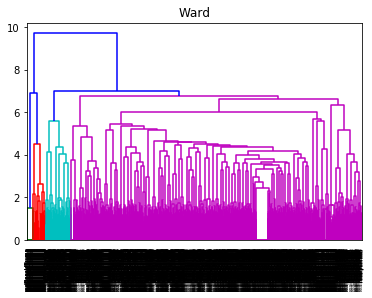

In [10]:
# calculate hierarchy

Z = linkage(dist_array, 'ward')

plt.title("Ward")

dendrogram(Z, labels=labels)

plt.show()

#single will fail and complete will not produce good results

In [11]:
# convert labels to (1, 2), not (0, 1)

# since that's what's returned by fcluster

Y = np.array([1 if e == 'realDonaldTrump' else 2 for e in labels])





In [12]:
# get cluster assignments

# threshold 9 was chosen empirically to yield 2 clusters

C = fcluster(Z, 9, criterion='distance') # returns 1, 2, ..., K

categories = set(C)

# sanity check: should be {1, 2}

print("values in C:", categories)



values in C: {1, 2}


In [13]:
## calculate the purity of our clusters ###

def purity(true_labels, cluster_assignments, categories):

  # maximum purity is 1, higher is better

  N = len(true_labels)



  total = 0.0

  for k in categories:

    max_intersection = 0

    for j in categories:

      intersection = ((cluster_assignments == k) & (true_labels == j)).sum()

      if intersection > max_intersection:

        max_intersection = intersection

    total += max_intersection

  return total / N



print("purity:", purity(Y, C, categories))

purity: 0.5605


In [14]:
# seeing which one the smaller cluster belongs to; finding donald trump and hillary tweets individually

if (C == 1).sum() < (C == 2).sum():

  d = 1

  h = 2

else:

  d = 2

  h = 1




In [15]:

actually_donald = ((C == d) & (Y == 1)).sum()

donald_cluster_size = (C == d).sum()

print("purity of @realDonaldTrump cluster:", float(actually_donald) / donald_cluster_size)





purity of @realDonaldTrump cluster: 0.9734513274336283


In [16]:
actually_hillary = ((C == h) & (Y == 2)).sum()

hillary_cluster_size = (C == h).sum()

print("purity of @HillaryClinton cluster:", float(actually_hillary) / hillary_cluster_size)



purity of @HillaryClinton cluster: 0.5357710651828299


In [17]:
# we observed through above that the smaller cluster is donald trump. 
# we have two clusters c1 and c2 and we see the tweets cluster in the smaller cluster is for donald or hillary 
# and observe its for hillary

In [18]:
#testing how a classifier would perform on the dataset

from sklearn.ensemble import RandomForestClassifier



rf = RandomForestClassifier()

rf.fit(X, df.handle)

print("classifier score:", rf.score(X, df.handle))



C:\Users\Aashya.Khanduja\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


classifier score: 0.9456859093730602


In [19]:
# clssifier comes to 90% while purity of clustering is 50%

In [20]:
# finding the words with the highest frequency

w2i = tfidf.vocabulary_

In [21]:
# calcultaing average vector in donald cluster -- d_avg

#tf-idf vectorizer todense() returns a matrix rather than array
# matrix always wants to be 2-D, so we convert to array in order to flatten

d_avg = np.array(x[C == d].mean(axis=0)).flatten()

d_sorted = sorted(w2i.keys(), key=lambda w: -d_avg[w2i[w]])



In [22]:
print("\nTop 10 'Donald cluster' words:")

print("\n".join(d_sorted[:10]))




Top 10 'Donald cluster' words:
thank
makeamericagreatagain
trump2016
new
will
trump
america
great
get
out


In [23]:
#hillary words 

h_avg = np.array(x[C == h].mean(axis=0)).flatten()

h_sorted = sorted(w2i.keys(), key=lambda w: -h_avg[w2i[w]])



print("\nTop 10 'Hillary cluster' words:")

print("\n".join(h_sorted[:10]))




Top 10 'Hillary cluster' words:
trump
hillary
we
will
our
he
donald
not
who
great
